In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, kruskal, linregress

csvpath = os.path.join("California_Fire_Incidents.csv")
calfire = pd.read_csv(csvpath)

# Set display options to show all columns

pd.set_option('display.max_columns',None)

# Convert datetime columns
calfire['Started'] = pd.to_datetime(calfire['Started'], format='ISO8601')
calfire['Updated'] = pd.to_datetime(calfire['Updated'], format='ISO8601')
calfire['Extinguished'] = pd.to_datetime(calfire['Extinguished'], format='ISO8601')

# Extract year and month
calfire['YearStarted'] = calfire['Started'].dt.year
calfire['MonthStarted'] = calfire['Started'].dt.month
calfire = calfire[calfire.YearStarted != 1969]

calfire = calfire.fillna({
    'AcresBurned': 0, 'AirTankers': 0, 'ConditionStatement': '', 'ControlStatement': '', 
    'CrewsInvolved': 0, 'Dozers': 0, 'Engines': 0, 'Extinguished': 0, 'Fatalities': 0,
    'FuelType': '', 'Helicopters': 0, 'Injuries': 0, 'PersonnelInvolved': 0,
    'SearchDescription': '', 'StructuresDamaged': 0, 'StructuresDestroyed': 0,
    'StructuresEvacuated': 0, 'StructuresThreatened': 0, 'WaterTenders': 0
})

# Convert data types
calfire.loc[:, 'AcresBurned'] = calfire['AcresBurned'].astype('int64')
calfire.loc[:, 'AirTankers'] = calfire['AirTankers'].astype('int64')
calfire.loc[:, 'CrewsInvolved'] = calfire['CrewsInvolved'].astype('int64')
calfire.loc[:, 'Dozers'] = calfire['Dozers'].astype('int64')
calfire.loc[:, 'Engines'] = calfire['Engines'].astype('int64')
calfire.loc[:, 'Fatalities'] = calfire['Fatalities'].astype('int64')
calfire.loc[:, 'Injuries'] = calfire['Injuries'].astype('int64')
calfire.loc[:, 'Helicopters'] = calfire['Helicopters'].astype('int64')
calfire.loc[:, 'PersonnelInvolved'] = calfire['PersonnelInvolved'].astype('int64')
calfire.loc[:, 'StructuresDamaged'] = calfire['StructuresDamaged'].astype('int64')
calfire.loc[:, 'StructuresDestroyed'] = calfire['StructuresDestroyed'].astype('int64')
calfire.loc[:, 'StructuresEvacuated'] = calfire['StructuresEvacuated'].astype('int64')
calfire.loc[:, 'StructuresThreatened'] = calfire['StructuresThreatened'].astype('int64')
calfire.loc[:, 'WaterTenders'] = calfire['WaterTenders'].astype('int64')

calfire


,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,Featured,Final,FuelType,Helicopters,Injuries,Latitude,Location,Longitude,MajorIncident,Name,PercentContained,PersonnelInvolved,Public,SearchDescription,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders,YearStarted,MonthStarted
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,0.0,2013,True,/incidents/2013/8/17/rim-fire/,,,Tuolumne,55,0.0,0.0,0.0,2013-09-06 18:30:00+00:00,0.0,False,True,,0.0,0.0,37.857000,3 miles east of Groveland along Hwy 120,-120.086000,False,Rim Fire,100.0,0.0,True,The Rim Fire was east of Groveland along Highw...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17 15:25:00+00:00,Finalized,0.0,0.0,0.0,0.0,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06 18:30:00+00:00,0.0,2013,8
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,0.0,2013,True,/incidents/2013/5/30/powerhouse-fire/,,,Los Angeles,19,0.0,0.0,0.0,2013-06-08 18:30:00+00:00,0.0,False,True,,0.0,0.0,34.585595,Angeles National Forest,-118.423176,False,Powerhouse Fire,100.0,0.0,True,The Powerhouse Fire burned in May and June 201...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30 15:28:00+00:00,Finalized,0.0,0.0,0.0,0.0,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08 18:30:00+00:00,0.0,2013,5
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,0.0,2013,True,/incidents/2013/7/15/mountain-fire/,,,Riverside,33,0.0,0.0,0.0,2013-07-30 18:00:00+00:00,0.0,False,True,,0.0,0.0,33.709500,Hwy 243 & Hwy 74 near Mountain Center,-116.728850,False,Mountain Fire,100.0,0.0,True,The Mountain Fire burned in July 2013 off High...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15 13:43:00+00:00,Finalized,0.0,0.0,0.0,0.0,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30 18:00:00+00:00,0.0,2013,7
3,27440.0,False,Tahoe National Forest,0.0,2013,False,/incidents/2013/8/10/american-fire/,,,Placer,31,0.0,0.0,0.0,2013-08-30 08:00:00+00:00,0.0,False,True,,0.0,0.0,39.120000,"Deadwood Ridge, northeast of Foresthill",-120.650000,False,American Fire,100.0,0.0,True,The American Fire burned in August 2013 off De...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10 16:30:00+00:00,Finalized,0.0,0.0,0.0,0.0,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30 08:00:00+00:00,0.0,2013,8
4,24251.0,False,Ventura County Fire/CAL FIRE,0.0,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,,Ventura,56,47.0,8.0,117.0,2013-05-11 06:30:00+00:00,0.0,False,True,,11.0,10.0,0.000000,Southbound Highway 101 at Camarillo Springs Ro...,0.000000,True,Springs Fire,100.0,2167.0,True,"The Springs Fire burned in May 2013, Southboun...","Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02 07:01:00+00:00,Finalized,6.0,10.0,0.0,0.0,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11 06:30:00+00:00,11.0,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,9.0,False,CAL FIRE / Riverside County Fire,0.0,2019,True,/incidents/2019/10/10/eagle-fire/,,,Riverside,33,0.0,0.0,0.0,2019-10-10 18:11:00+00:00,0.0,False,True,,0.0,0.0,33.827979,"Eagle Canyon Rd. and Cajalco Rd., southwest of...",-117.499619,False,Eagle Fire,100.0,0.0,True,"The Eagle Fire started on October 10, 2019 nea...",NaN,2019-10-10 12:08:00+00:00,Finalized,0.0,0.0,0.0,0.0,6e93b252-99a3-4214-9921-238373b17535,2019-10-10 18:11:59.733000+00:00,0.0,2019,10
1632,2.0,False,CAL FIRE Nevada-Yuba-Placer Unit,0.0,2019,True,/incidents/2019/6/28/long-fire/,,,Nevada,29,0.0,0.0,0.0,2019-06-28 17:33:00+00:00,0.0,False,True,,0.0,0.0,39.409722,"Off of Long Point Road and Old Mill Road, Sou...",-121.000556,False,Long Fire,100.0,0.0,True,"

In [2]:
# Drop unnecessary columns
columns_to_drop = ['Active', 'Featured', 'Final', 'PercentContained', 'Public', 'SearchKeywords', 'Status']
calfire.drop(columns_to_drop, axis='columns', inplace=True)


In [3]:
# Calculate average burned area per firefighter
calfire['AcresPerFirefighter'] = calfire['AcresBurned'] / calfire['PersonnelInvolved'].replace(0, 1)

In [4]:
# Set Seaborn style
sns.set_theme(style="darkgrid")

# Ensure only numeric columns are aggregated
calfire_grouped = calfire.groupby('YearStarted', as_index=False).sum(numeric_only=True)

# Set Seaborn style for beautiful visuals
sns.set_theme(style="whitegrid")

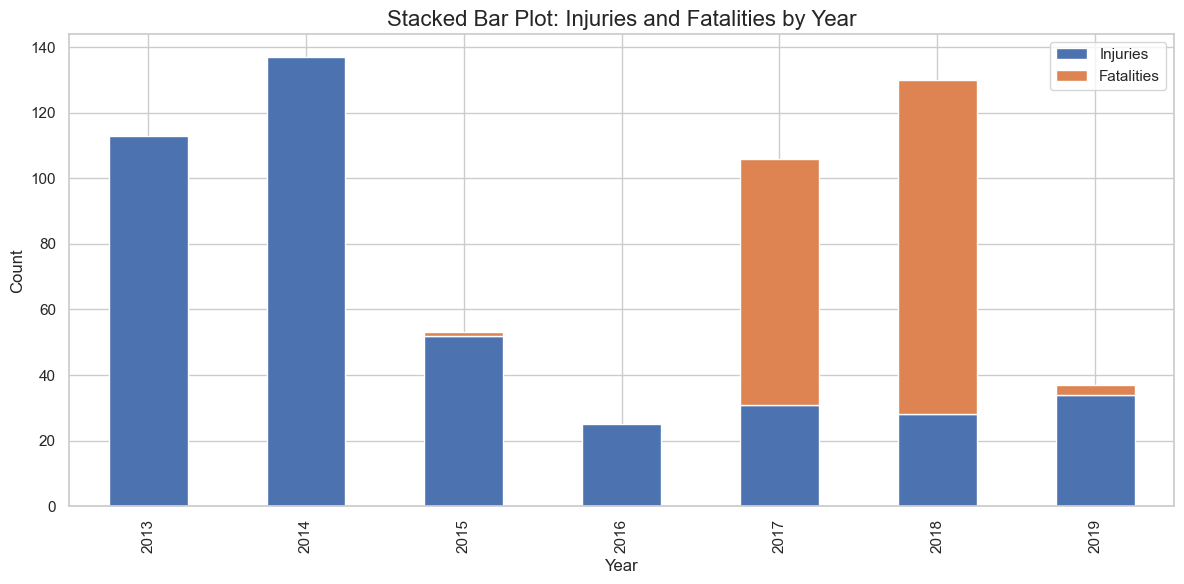

In [5]:
# Plot 1: Injuries and Fatalities Over Time
injuries_fatalities_by_year = calfire_grouped[['YearStarted', 'Injuries', 'Fatalities']]
injuries_fatalities_by_year.set_index('YearStarted').plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Plot: Injuries and Fatalities by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

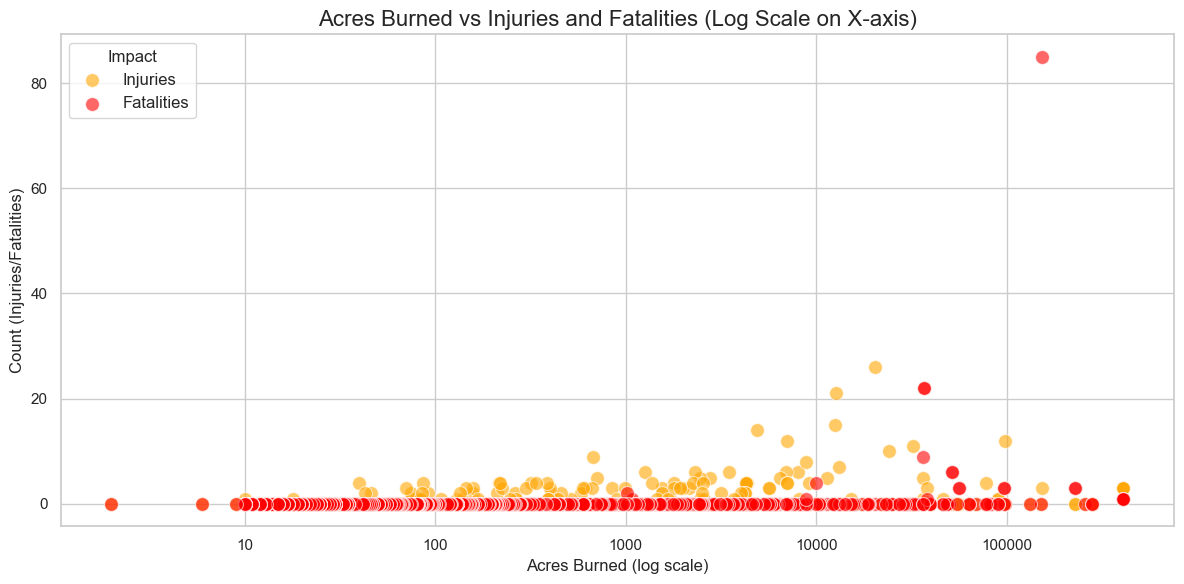

In [6]:
# Plot 2: Acres Burned vs Injuries and Fatalities (Scatter Plot)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=calfire, x='AcresBurned', y='Injuries', alpha=0.6, color='orange', label='Injuries', s=100)
sns.scatterplot(data=calfire, x='AcresBurned', y='Fatalities', alpha=0.6, color='red', label='Fatalities', s=100)
plt.xscale('log')
# Define the tick positions for natural numbers (log scale)
ticks = [10, 100, 1000, 10000, 100000]
plt.xticks(ticks, labels=[str(i) for i in ticks])

plt.title('Acres Burned vs Injuries and Fatalities (Log Scale on X-axis)', fontsize=16)
plt.xlabel('Acres Burned (log scale)', fontsize=12)
plt.ylabel('Count (Injuries/Fatalities)', fontsize=12)
plt.legend(title='Impact', fontsize=12)
plt.tight_layout()
plt.show()


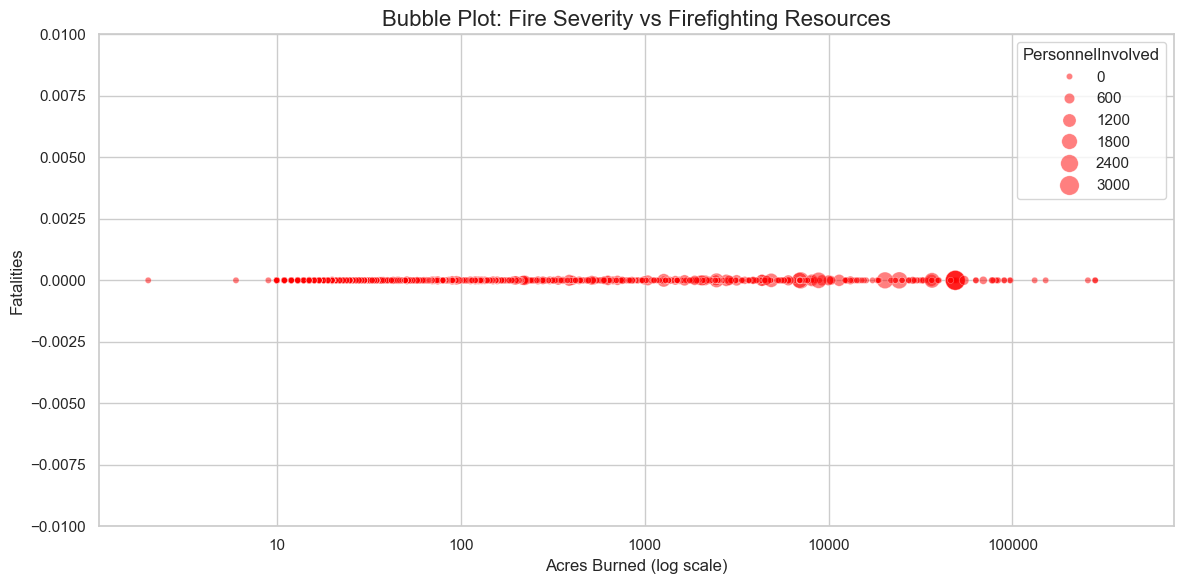

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=calfire, x='AcresBurned', y='Fatalities', size='PersonnelInvolved', sizes=(20, 200), alpha=0.5, color='red')

# Set log scale for x-axis and fix the ticks
plt.xscale('log')

# Define the tick positions for natural numbers (log scale)
ticks = [10, 100, 1000, 10000, 100000]
plt.xticks(ticks, labels=[str(i) for i in ticks])

# Title and labels
plt.title('Bubble Plot: Fire Severity vs Firefighting Resources', fontsize=16)
plt.xlabel('Acres Burned (log scale)', fontsize=12)
plt.ylabel('Fatalities', fontsize=12)

# Limit y-axis to 0-20 and move up slightly
plt.ylim(-0.01, 0.01)  # Set minimum y-axis value to 1 instead of 0

# Adjust layout and show plot
plt.tight_layout()
plt.show()

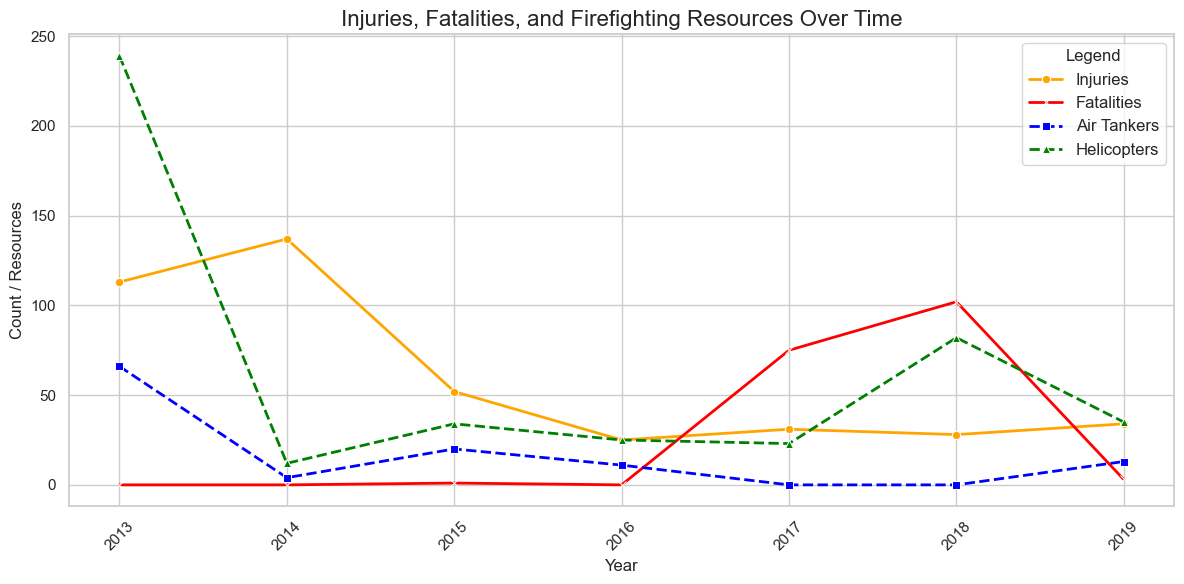

In [8]:
# Plot 3: Comparison of Injuries and Fatalities with Firefighting Resources Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=calfire_grouped, x='YearStarted', y='Injuries', label='Injuries', marker='o', color='orange', linewidth=2)
sns.lineplot(data=calfire_grouped, x='YearStarted', y='Fatalities', label='Fatalities', marker='x', color='red', linewidth=2)
sns.lineplot(data=calfire_grouped, x='YearStarted', y='AirTankers', label='Air Tankers', marker='s', color='blue', linewidth=2, linestyle='--')
sns.lineplot(data=calfire_grouped, x='YearStarted', y='Helicopters', label='Helicopters', marker='^', color='green', linewidth=2, linestyle='--')
plt.title('Injuries, Fatalities, and Firefighting Resources Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count / Resources', fontsize=12)
plt.legend(title='Legend', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()